Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
(10000, 11)
   CreditScore Geography  Gender  Age  Tenure    Balance  NumOfProducts  \
0          619    France  Female   42       2       0.00              1   
1          608     Spain  Female   41       1   83807.86              1   
2          502    France  Female   42       8  159660.80              3   
3          699    France  Female   39       1       0.00              2   
4          850     Spain  Female   43       2  125510.82              1   

   HasCrCard  IsActiveMember  EstimatedSalary  Exited  
0          1               1        101348.88       1  
1          0               1        112542.58       0  
2          1               0        113931.57       1  
3          0               0         93826.63       0  
4          1               1         79084.10       0  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 99

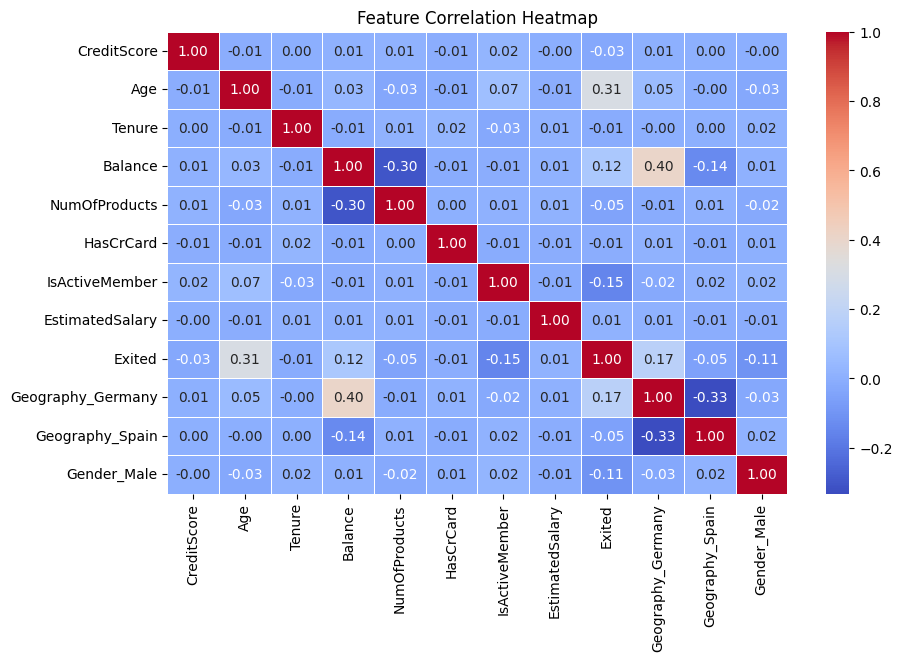

<ipython-input-7-c9137ab62e1a>:52: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(x=df["Age"], y=df["Exited"], ci=None, palette="coolwarm")
<ipython-input-7-c9137ab62e1a>:52: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=df["Age"], y=df["Exited"], ci=None, palette="coolwarm")


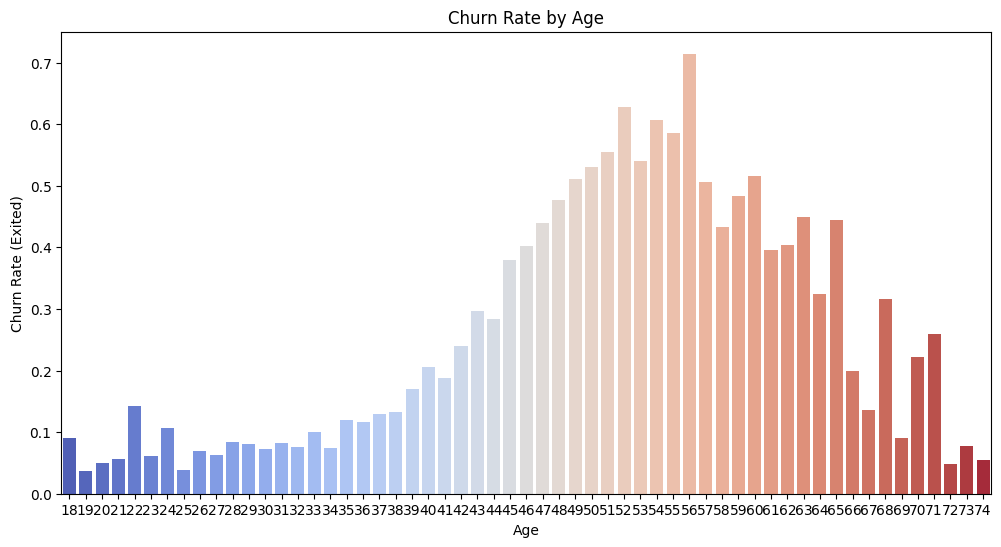

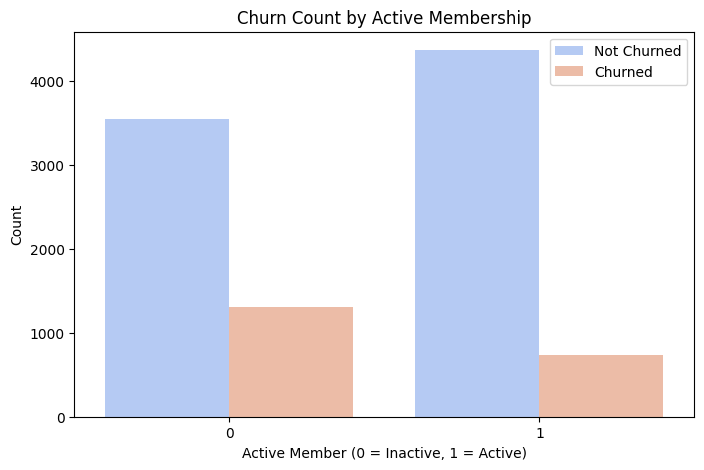

      Actual  Predicted
8819       0          0
6460       0          0
7936       0          0
9331       0          0
3363       0          0
...      ...        ...
9412       0          0
5369       1          1
453        0          0
5227       0          0
719        0          0

[1990 rows x 2 columns]
Accuracy: 0.85
[[1533   56]
 [ 233  168]]


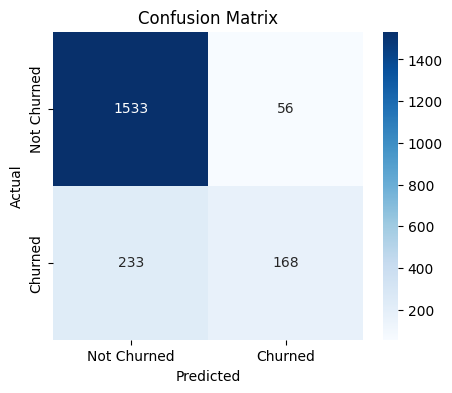

Index(['CreditScore', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary', 'Geography_Germany',
       'Geography_Spain', 'Gender_Male'],
      dtype='object')
Churn Prediction: [0]


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from google.colab import drive
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score
import joblib

drive.mount('/content/drive')
dataset_path = "/content/drive/MyDrive/project/customer_churn.csv"
df = pd.read_csv(dataset_path)

df.drop("Surname", axis=1, inplace=True)
df.drop("CustomerId", axis=1, inplace=True)


print(df.shape)
print(df.head())
print(df.info())
print(df.isnull().sum())
print(df.duplicated().sum())

#converting to numerical values
df["Geography"] = df["Geography"].astype("category")
df["Gender"] = df["Gender"].astype("category")
df = pd.get_dummies(df, columns=["Geography", "Gender"], drop_first=True)
df[["Geography_Germany", "Geography_Spain"]] = df[["Geography_Germany", "Geography_Spain"]].astype(int)
df[["Gender_Male"]] = df[["Gender_Male"]].astype(int)



# Handle outliers using IQR
outlier_cols = ["CreditScore", "Age", "Balance", "EstimatedSalary"]  # Exclude "Exited"
for col in outlier_cols:
  Q1 = df[col].quantile(0.25)
  Q3 = df[col].quantile(0.75)
  IQR = Q3 - Q1
  df = df[(df[col] >= (Q1 - 2.5 * IQR)) & (df[col] <= (Q3 + 2.5 * IQR))]


# Correlation heatmap
correlation_matrix = df.corr()
plt.figure(figsize=(10, 6))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Feature Correlation Heatmap")
plt.show()

plt.figure(figsize=(12, 6))
sns.barplot(x=df["Age"], y=df["Exited"], ci=None, palette="coolwarm")
plt.xlabel("Age")
plt.ylabel("Churn Rate (Exited)")
plt.title("Churn Rate by Age")
plt.show()


plt.figure(figsize=(8, 5))
sns.countplot(x="IsActiveMember", hue="Exited", data=df, palette="coolwarm")
plt.xlabel("Active Member (0 = Inactive, 1 = Active)")
plt.ylabel("Count")
plt.title("Churn Count by Active Membership")
plt.legend(["Not Churned", "Churned"])
plt.show()

#Train-test split
X = df.drop(columns=['Exited'])
y = df['Exited']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Model Training
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Predictions
y_pred = model.predict(X_test)
result=pd.DataFrame({'Actual':y_test,'Predicted':y_pred})
print(result)


accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy:.2f}")
cm = confusion_matrix(y_test, y_pred)
print(cm)

plt.figure(figsize=(5, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Churned", "Churned"], yticklabels=["Not Churned", "Churned"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

#Deployement
joblib.dump(model, "churn_model.pkl")

print(X_train.columns)
new_customer_data = pd.DataFrame([{
    "CreditScore": 700,
    "Age": 40,
    "Tenure": 5,
    "Balance": 50000,
    "NumOfProducts": 2,
    "HasCrCard": 1,
    "IsActiveMember": 0,
    "EstimatedSalary": 100000,
    "Geography_Germany": 0,
    "Geography_Spain": 1,
    "Gender_Male": 1
}])

loaded_model = joblib.load("churn_model.pkl")
prediction = loaded_model.predict(new_customer_data)
print("Churn Prediction:", prediction)


